In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import AllChem, Descriptors, Draw, rdMolDescriptors, Lipinski, Descriptors3D
from rdkit.ML.Cluster import Butina
from rdkit.ML.Descriptors import MoleculeDescriptors
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform, pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
import matplotlib.ticker as ticker
from rdkit.Chem.Descriptors3D import Asphericity, Eccentricity, InertialShapeFactor, NPR1, NPR2, PMI1, PMI2, PMI3, RadiusOfGyration, SpherocityIndex
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

In [2]:
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")

In [3]:
# Accessing Excel spreadsheets
data = pd.read_excel('./Data/molecules.xlsx')

In [4]:
# Handling missing data
data['Anode Limit'].fillna(0, inplace=True)
data['Solubility Energy'].fillna(0, inplace=True)

# Converting to standardized SMILES representation
data['SMILES'] = data['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))

In [5]:
# Molecular descriptors for training a clustering analysis model capable of clustering based on solubility.
def calculate_descriptors_sol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    descriptors = {}
    # Molecular descriptors describing the basic structure of reactants.
    descriptors['NumAtoms'] = mol.GetNumAtoms()  # Number of atoms in a molecule.
    descriptors['NumHeavyAtoms'] = mol.GetNumHeavyAtoms()  # Number of heavy atoms in a molecule.
    descriptors['NumHeteroatoms'] = Descriptors.NumHeteroatoms(mol)  # Number of heteroatoms in a molecule.
    descriptors['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)  # Number of rotatable bonds in a molecule.
    descriptors['NumRings'] = Descriptors.RingCount(mol)  # Number of heterocycles in a molecule.
    descriptors['NumAromaticRings'] = Descriptors.NumAromaticRings(mol)  # Number of aromatic heterocycles in a molecule.
    descriptors['NumAliphaticRings'] = Descriptors.NumAliphaticRings(mol)  # Number of aliphatic rings in a molecule.
    descriptors['NumSaturatedRings'] = Descriptors.NumSaturatedRings(mol)  # Number of saturated heterocycles in a molecule.
    descriptors['FractionCSP3'] = Lipinski.FractionCSP3(mol)  # Proportion of carbon atoms undergoing sp3 hybridization.
    descriptors['FormalCharge'] = sum([atom.GetFormalCharge() for atom in mol.GetAtoms()])  # Total charge of the molecule.
    descriptors['NumAromaticCarbocycles'] = Descriptors.NumAromaticCarbocycles(mol)  # Number of aromatic carbon rings, indirectly describing the conjugation properties.
    descriptors['NumAromaticHeterocycles'] = Descriptors.NumAromaticHeterocycles(mol)  # Count of aromatic heterocycles, indirectly characterizing the conjugation properties.
    descriptors['NumSaturatedCarbocycles'] = Descriptors.NumSaturatedCarbocycles(mol)  # Number of saturated carbon rings.
    
    # Molecular descriptor describing the size of reactants, whereby larger anions are generally considered less soluble.
    descriptors['TPSA'] = Descriptors.TPSA(mol)# Solubility, TPSA (Topological Polar Surface Area), is calculated based on the molecular's topology and represents the polar surface area. Larger TPSA values are typically associated with larger molecular surface area, which may indicate the presence of larger anions.
    descriptors['MolWt'] = Descriptors.MolWt(mol)# Solubility, MolWt (molecular weight), refers to the relative mass of a molecule. Larger relative molecular weights may be associated with larger anions.
    descriptors['HeavyAtomMolWt'] = Descriptors.HeavyAtomMolWt(mol)# Solubility, HeavyAtomMolWt, represents the sum of the relative molecular weights of the heavy atoms in a molecule. Larger HeavyAtomMolWt values may indicate the presence of larger anions.
    descriptors['NumHDonors'] = Descriptors.NumHDonors(mol) # Hydrogen bond donor count (HBD)
    descriptors['NumHAcceptors'] = Descriptors.NumHAcceptors(mol) # Hydrogen bond acceptor count (HBA)
  
    # Generate three-dimensional molecular descriptors.
    AllChem.EmbedMolecule(mol, useRandomCoords=True,maxAttempts=5000)# Convert two-dimensional molecular graph into three-dimensional molecular coordinates.
    AllChem.MMFFOptimizeMolecule(mol)# Perform conformational optimization of the molecule using MMFF94 force field.
    mol=Chem.AddHs(mol)# Add hydrogen atoms to the 3D conformation of the molecule.
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())# Generate a 3D conformation for molecule M2 and optimize it using the ETKDG algorithm.
    descriptors['Asphericity'] = Descriptors3D.Asphericity(mol)  # The sphericity of a molecule refers to the degree of irregularity in its shape, describing how far it deviates from a perfect sphere.
    descriptors['Eccentricity'] = Descriptors3D.Eccentricity(mol)  # The eccentricity of a molecule describes the degree of elongation or stretching in its shape. It quantifies how much the molecule deviates from a perfect circle or sphere by measuring the ratio of its major axis to its minor axis.
    descriptors['InertialShapeFactor'] = Descriptors3D.InertialShapeFactor(mol)  # The moment of inertia shape factor of a molecule describes the degree of asymmetry in its shape. It quantifies the molecule's deviation from a symmetrical or balanced configuration, reflecting the distribution of mass around its axis of rotation.
    descriptors['NPR1'] = Descriptors3D.NPR1(mol)  # One of the principal axis ratios of a molecule describes the degree of planarity in its shape. It represents the ratio between the lengths of the molecule's major axis and its minor axis, indicating how flattened or elongated the molecule appears in relation to its overall structure.
    descriptors['NPR2'] = Descriptors3D.NPR2(mol)  # Another principal axis ratio of a molecule delineates the level of planarity in its shape. It characterizes the ratio between the lengths of the molecule's longest axis and its second longest axis, elucidating the extent to which the molecule appears flattened or elongated within its overall structure.
    descriptors['PMI1'] = Descriptors3D.PMI1(mol)  # One of the principal moments of inertia of a molecule delineates the distribution and rotational properties of its shape. It captures the molecule's susceptibility to rotation and reveals the spatial arrangement of its constituent atoms within its overall structure.
    descriptors['PMI2'] = Descriptors3D.PMI2(mol)  # The second principal moment of inertia of a molecule elucidates the distribution and rotational characteristics of its shape. It imparts insights into the molecule's propensity for rotation, unveiling the spatial arrangement and orientation of its constituent elements within its overarching structure.
    descriptors['PMI3'] = Descriptors3D.PMI3(mol)  # The third principal moment of inertia of a molecule delineates the dispersion of its shape and the rotational properties it exhibits. It provides a profound depiction of the molecule's capacity for rotation, illuminating the intricate arrangement and dynamic characteristics of its constituent components within its overarching molecular framework.
    descriptors['RadiusOfGyration'] = Descriptors3D.RadiusOfGyration(mol)  # The gyradius of a molecule encapsulates its expansibility and flexibility, serving as a measure of its rotational radius. It embodies the inherent ability of the molecule to undergo rotational motion, revealing the extent to which it can extend and adapt, exemplifying its structural adaptability and dynamic nature.
    descriptors['SpherocityIndex'] = Descriptors3D.SpherocityIndex(mol)  # The sphericity index of a molecule characterizes the degree of spherical shape exhibited by its structure. It quantifies the molecule's resemblance to a perfect sphere, conveying information about its overall roundness and compactness. The sphericity index provides insight into the molecular geometry, reflecting the level of symmetry and spherical symmetry present within the molecule's architecture.
    
    
    return pd.Series(descriptors)

In [6]:
descriptors_sol = data['SMILES'].apply(calculate_descriptors_sol)
data_sol = pd.concat([data, descriptors_sol], axis=1)

In [7]:
# The molecular descriptors employed for training a clustering analysis model capable of categorizing structures based on their anodic limit structural features. 
def calculate_descriptors_Val(smiles):
    mol = Chem.MolFromSmiles(smiles)
    descriptors = {}
    descriptors['NumAtoms'] = mol.GetNumAtoms()  
    descriptors['NumHeavyAtoms'] = mol.GetNumHeavyAtoms()  
    descriptors['NumHeteroatoms'] = Descriptors.NumHeteroatoms(mol)  
    descriptors['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)  
    descriptors['NumRings'] = Descriptors.RingCount(mol)  
    descriptors['NumAromaticRings'] = Descriptors.NumAromaticRings(mol)  
    descriptors['NumAliphaticRings'] = Descriptors.NumAliphaticRings(mol) 
    descriptors['NumSaturatedRings'] = Descriptors.NumSaturatedRings(mol)  
    descriptors['FractionCSP3'] = Lipinski.FractionCSP3(mol)  
    descriptors['FormalCharge'] = sum([atom.GetFormalCharge() for atom in mol.GetAtoms()])  
    descriptors['NumAromaticCarbocycles'] = Descriptors.NumAromaticCarbocycles(mol)  
    descriptors['NumAromaticHeterocycles'] = Descriptors.NumAromaticHeterocycles(mol)  
    descriptors['NumSaturatedCarbocycles'] = Descriptors.NumSaturatedCarbocycles(mol) 
    
    # Molecular descriptors are utilized to depict the spatial impediments and stereochemical properties of reactant structures.
    descriptors['LogP'] = Descriptors.MolLogP(mol)  # The molecular partition coefficient signifies the distribution of a molecule between different phases, typically between a nonpolar phase (e.g., a solvent) and a polar phase (e.g., water).
    descriptors['MR'] = Descriptors.MolMR(mol) # The molecular polarizability refers to a measure of a molecule's polarity and can be utilized as an indicator of the degree of electron cloud overlap within the molecule. It can provide insights into both solubility and anodic limits, offering a comprehensive perspective.
    
    
    # Getting the valence of the element S
    for atom in mol.GetAtoms():
        atom_symbol = atom.GetSymbol()
        if atom_symbol  == 'S':
            descriptors['Valence_S'] = atom.GetTotalValence() 

    # sp2 Hybridization ratio of element C 
    total_carbons = 0
    sp2_carbons = 0

    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 6: 
            total_carbons += 1
            hybridization = atom.GetHybridization()
            if hybridization == Chem.HybridizationType.SP2:
                sp2_carbons += 1

    sp2_ratio = sp2_carbons / total_carbons
    descriptors['FractionCSP2'] = sp2_ratio 
    
    # Number of conjugated π-electrons in the ion
    conjugated_pi_electrons = 0

    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.DOUBLE or bond.GetBondType() == Chem.BondType.AROMATIC:
            conjugated_pi_electrons += 2  

    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 6:
            hybridization = atom.GetHybridization()
            if hybridization == Chem.HybridizationType.SP2:
                conjugated_pi_electrons += 1  

    descriptors['conjugated_pi_electrons'] = conjugated_pi_electrons
    

    AllChem.EmbedMolecule(mol, useRandomCoords=True,maxAttempts=5000)
    AllChem.MMFFOptimizeMolecule(mol)
    mol=Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    descriptors['Asphericity'] = Descriptors3D.Asphericity(mol)
    descriptors['Eccentricity'] = Descriptors3D.Eccentricity(mol)  
    descriptors['InertialShapeFactor'] = Descriptors3D.InertialShapeFactor(mol) 
    descriptors['NPR1'] = Descriptors3D.NPR1(mol) 
    descriptors['NPR2'] = Descriptors3D.NPR2(mol) 
    descriptors['PMI1'] = Descriptors3D.PMI1(mol)
    descriptors['PMI2'] = Descriptors3D.PMI2(mol)
    descriptors['PMI3'] = Descriptors3D.PMI3(mol)  
    descriptors['RadiusOfGyration'] = Descriptors3D.RadiusOfGyration(mol) 
    descriptors['SpherocityIndex'] = Descriptors3D.SpherocityIndex(mol)
    
    
    return pd.Series(descriptors)

In [8]:
descriptors_Val = data['SMILES'].apply(calculate_descriptors_Val)
descriptors_Val['Valence_S'].fillna(0, inplace=True)
data_Val = pd.concat([data, descriptors_Val], axis=1)

In [9]:
# data normalization (solubility model）
scaler = MinMaxScaler()
scaled_data_sol = scaler.fit_transform(data_sol.iloc[:, 3:])
scaled_data_sol = pd.DataFrame(scaled_data_sol, columns=data_sol.columns[3:])
data_sol = pd.concat([data_sol.iloc[:, :3], scaled_data_sol], axis=1)
# data normalization (anode limit model）
scaler = MinMaxScaler()
scaled_data_Val = scaler.fit_transform(data_Val.iloc[:, 3:])
scaled_data_Val = pd.DataFrame(scaled_data_Val, columns=data_Val.columns[3:])
data_Val = pd.concat([data_Val.iloc[:, :3], scaled_data_Val], axis=1)

In [10]:
# solubility model
X_sol = data_sol.iloc[:, 3:]
model_sol = AgglomerativeClustering(distance_threshold=0.5, n_clusters=None)
model_sol=model_sol.fit(X_sol)
model_sol.fit(X_sol)

AgglomerativeClustering(distance_threshold=0.5, n_clusters=None)

In [11]:
# anode limit model
X_Val = data_Val.iloc[:, 3:]
model_Val = AgglomerativeClustering(distance_threshold=0.5, n_clusters=None)
model_Val=model_Val.fit(X_Val)
model_Val.fit(X_Val)

AgglomerativeClustering(distance_threshold=0.5, n_clusters=None)

In [12]:
# Drawing tree diagrams (dendrograms) for hierarchical clustering
def plot_dendrogram(model, line_thickness=0.5, **kwargs):
    # Create a counting array of sample sizes
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    # Calculate the number of samples under each node
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Creating a link matrix
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Tree diagrams
    # Plot the dendrogram without drawing the lines
    dendrogram_results = dendrogram(linkage_matrix, no_plot=True, **kwargs)

    # Now, we will draw the lines manually, using the color information
    # provided in dendrogram_results['color_list']
    for (x, y, color) in zip(dendrogram_results['icoord'], dendrogram_results['dcoord'], dendrogram_results['color_list']):
        plt.plot(x, y, lw=line_thickness, color=color)  # Use the original color and set line thickness

    # Set y-axis from 0 to max distance + some margin
    plt.ylim(0, linkage_matrix[:, 2].max() * 1.05)

    # Set x-axis from 0 to the max index of the leaves
    plt.xlim(0, 10*len(dendrogram_results['ivl']))
    
    # Returns a list of labels for leaf nodes
    return dendrogram_results["ivl"]

# Example usage:
# Assuming 'model' is an instance of a clustering model (e.g., from sklearn.cluster.AgglomerativeClustering)
# plt.figure(figsize=(10, 2))
# plot_dendrogram(model, line_thickness=2.0)  # Increase line_thickness to get thicker lines
# plt.show()


In [13]:
# Set as Arial
plt.rcParams['font.family'] = 'Arial'

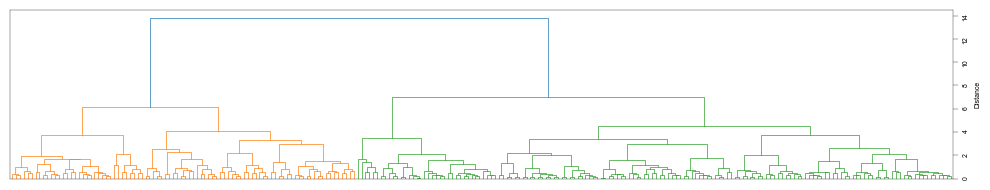

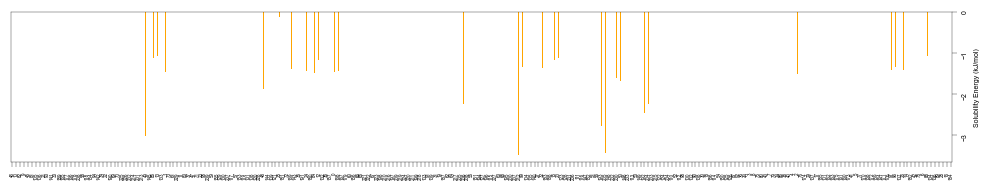

In [14]:
# 设置相同的图形尺寸
figsize_cluster = (10, 2)
figsize_bar = (10, 2)
fontsize=5
fontsize_x=3.25
width = 0.25

# Clustering by solubility descriptors
plt.figure(figsize=figsize_cluster)  
leaf_nodes = plot_dendrogram(model_sol, truncate_mode='lastp', p=len(data_sol), show_contracted=True)
# plt.title('Hierarchical Clustering Dendrogram by Solubility Energy', fontsize=fontsize, fontname='Arial')

plt.ylabel('Distance', fontsize=fontsize, fontname='Arial')
#plt.tick_params(axis='x', labelsize=fontsize, which='both')  
plt.tick_params(axis='x', width=width, which='both', bottom=False, top=False, labelbottom=False) 
plt.tick_params(axis='y', width=width, labelsize=fontsize) 

ax = plt.gca()

ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')

ax.tick_params(axis='y', labelsize=fontsize, labelrotation=90)


ax.spines['top'].set_linewidth(width)  
ax.spines['right'].set_linewidth(width)  
ax.spines['bottom'].set_linewidth(width) 
ax.spines['left'].set_linewidth(width) 
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True)) # Set y-axis label format to integer

plt.tight_layout()  
plt.savefig('./Figure/Cluster_by_sol.tif', format='tif', dpi=300, bbox_inches='tight')  # Save the tree diagram


# Drawing bar graphs
fig, ax = plt.subplots(figsize=figsize_bar)
leaf_nodes_int = [int(node) for node in leaf_nodes]
dataset_reorder = data_sol.reindex(leaf_nodes_int)
df = pd.DataFrame({'Solubility Energy': dataset_reorder['Solubility Energy']})
df.plot.bar(rot=90, ax=ax, color=['orange'], fontsize=fontsize_x, width=width)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True)) # Set y-axis label format to integer
ax.set_ylabel("Solubility Energy (kJ/mol)", fontsize=fontsize, fontname='Arial')
ax.tick_params(axis='y', labelsize=fontsize, labelrotation=90)
plt.tick_params(axis='x', width=width)
plt.tick_params(axis='y', width=width)



ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')

ax.get_legend().remove()

ax.spines['top'].set_linewidth(width)  
ax.spines['right'].set_linewidth(width) 
ax.spines['bottom'].set_linewidth(width)
ax.spines['left'].set_linewidth(width)   
plt.tight_layout() 
plt.savefig('./Figure/Solvation_energy.tif', format='tif', dpi=300, bbox_inches='tight')

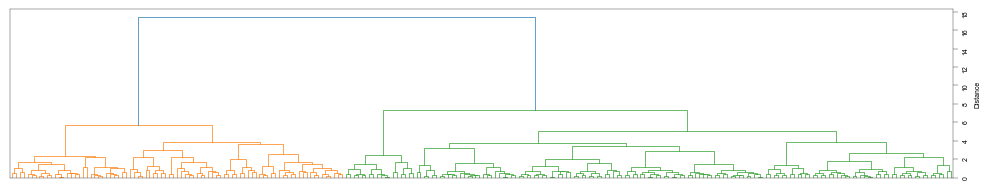

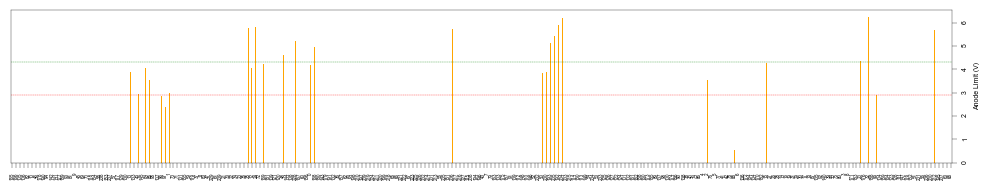

In [15]:
# Clustering by solubility descriptors
plt.figure(figsize=figsize_cluster)  
leaf_nodes = plot_dendrogram(model_Val, truncate_mode='lastp', p=len(data_Val), show_contracted=True)

# plt.title('Hierarchical Clustering Dendrogram by Anode Limit', fontsize=fontsize, fontname='Arial')
plt.ylabel('Distance', fontsize=fontsize, fontname='Arial')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', labelsize=fontsize) 

ax = plt.gca()

ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')
ax.tick_params(axis='y', width=width, labelsize=fontsize, labelrotation=90)

ax.spines['top'].set_linewidth(width)  
ax.spines['right'].set_linewidth(width)  
ax.spines['bottom'].set_linewidth(width) 
ax.spines['left'].set_linewidth(width)  
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True)) # Set y-axis label format to integer

plt.tight_layout()  
plt.savefig('./Figure/Cluster_by_Val.tif', format='tif', dpi=300, bbox_inches='tight')  # Save the tree diagram

# Drawing bar graphs
fig, ax = plt.subplots(figsize=figsize_bar)
leaf_nodes_int = [int(node) for node in leaf_nodes]
dataset_reorder = data_Val.reindex(leaf_nodes_int)
df = pd.DataFrame({'Anode Limit': dataset_reorder['Anode Limit']})
df.plot.bar(rot=90, ax=ax, color=['orange'], fontsize=fontsize_x, width=width)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True)) # Set y-axis label format to integer
ax.set_ylabel("Anode Limit (V)", fontsize=fontsize, fontname='Arial')
plt.tick_params(axis='x', width=width)
plt.tick_params(axis='y', width=width)

ax.tick_params(axis='y', labelsize=fontsize, labelrotation=90)

ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')

ax.get_legend().remove()
ax.axhline(y=2.9, color='red', linestyle='--', linewidth=width) 
ax.axhline(y=4.3, color='green', linestyle='--', linewidth=width)

ax.spines['top'].set_linewidth(width) 
ax.spines['right'].set_linewidth(width) 
ax.spines['bottom'].set_linewidth(width)
ax.spines['left'].set_linewidth(width) 
plt.tight_layout() 
plt.savefig('./Figure/Anode_limit.tif', format='tif', dpi=300, bbox_inches='tight')

In [16]:
# Save data_sol as an Excel spreadsheet
data_sol.to_excel('./Data/data_sol.xlsx', index=False)

# Save data_Val as an Excel spreadsheet
data_Val.to_excel('./Data/data_Val.xlsx', index=False)